In [ ]:
#### IMPORTING LIBRARIES...

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
transformTrain = transforms.Compose([transforms.ToTensor(), transforms.RandomHorizontalFlip(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
transformTest = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

#transform = transforms.ToTensor()
train_data = datasets.CIFAR10(root = '/content/', train = True, transform=transformTrain, download = True)
test_data = datasets.CIFAR10(root = '/content/', train = False, transform=transformTest, download = True)

Extracting /content/cifar-10-python.tar.gz to /content/
Files already downloaded and verified


In [ ]:
torch.manual_seed(30)
train_loader  = DataLoader(dataset = train_data, batch_size = 20, shuffle = True, pin_memory=True)
test_loader = DataLoader(dataset=test_data, batch_size=10, shuffle = False, pin_memory=True)

In [ ]:
def classes_sample(classes):
  pred_cls = []
  for cls in (classes):
    labels = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    pred_cls.append(labels[cls])
  return (pred_cls)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The shape of first train batch is:  torch.Size([20, 3, 32, 32])
The shape of first test batch is:  torch.Size([20])
predicted classes are:  ['bird', 'ship', 'horse', 'frog', 'ship', 'car', 'cat', 'horse', 'horse', 'deer', 'plane', 'deer', 'truck', 'deer', 'truck', 'dog', 'deer', 'frog', 'car', 'horse']


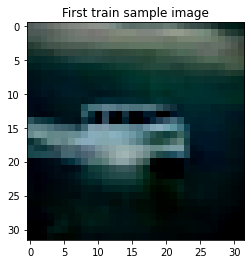

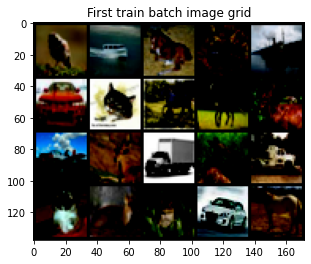

In [ ]:
for images, classes in (train_loader):
  break

im_train_sample = images
im_classes_sample = classes

print("The shape of first train batch is: ", im_train_sample.shape)
print("The shape of first test batch is: ", im_classes_sample.shape)

plt.figure(figsize = (8,4))
plt.title("First train sample image")
plt.imshow(np.transpose(im_train_sample[1].numpy(), (1,2,0)))

plt.figure(figsize=(10,4))
plt.title("First train batch image grid")
im_grid = make_grid(im_train_sample, nrow = 5).numpy()

print("predicted classes are: ", classes_sample(im_classes_sample))
plt.imshow(np.transpose(im_grid, (1,2,0)));

In [ ]:
class CNN_model_3(nn.Module):

  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(3,3,3, bias=False)
    self.conv2 = nn.Conv2d(3,16,3)
    self.pool1 = nn.MaxPool2d(kernel_size = (2,2), stride =2)
    self.conv3 = nn.Conv2d(16,45,3, padding=1, stride = 2)
    self.pool2 = nn.MaxPool2d(kernel_size = (2,2), stride =2)
    self.drp = nn.Dropout2d(p= 0.05)
    self.rel = nn.ReLU(inplace = True)
    self.fc1 = nn.Linear(7*7*45, 80)
    self.fc2 = nn.Linear(80,10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool1(F.relu(self.conv2(x)))
    x = F.relu(self.conv3(x))
    x = self.drp(x)
    x = x.view(-1, 7*7*45)
    x = F.relu(self.fc1(x))
    x = self.rel(x)
    x =  F.relu(self.fc2(x))
    x = self.rel(x)
    return F.log_softmax(x, dim=1)

In [ ]:
torch.manual_seed(30)
model = CNN_model_3()
model

CNN_model_3(
  (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (conv2): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 45, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (drp): Dropout2d(p=0.05, inplace=False)
  (rel): ReLU(inplace=True)
  (fc1): Linear(in_features=2205, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
def GetAccuarcy(yp, yt):
  return(accuracy_score(yt, yp))

In [ ]:
##### TRAINING....

torch.manual_seed(30)

#### SAVING ALL THE RESULTS

training_loss = []
testing_loss = []
training_accuracy = []
testing_accuracy = []
total_test_correct = 0
total_test_im = 0
epochs = 5

for i in range(epochs):

  for iter_num, (xtrain, ytrain) in enumerate(train_loader):
    iter_num+=1
    ypred = model(xtrain)                                        #forward propagation
    train_loss = criterion(ypred, ytrain)

    predicted = torch.max(ypred.data, 1)[1]
    
    train_accuracy = GetAccuarcy(predicted, ytrain)*100
 
    optimizer.zero_grad()

    train_loss.backward()                                         # Backpropagation

    optimizer.step()

    if (iter_num%1000 == 0):
      print("Epoch : {} | Loss: {} | Training accuracy : {}%".format(i, train_loss, train_accuracy))
  train_accuracy = GetAccuarcy(predicted, ytrain)*100
  training_accuracy.append(train_accuracy)
  training_loss.append(train_loss)

#### TESTING....

with torch.no_grad():
  for iter_num, (xtest, ytest) in enumerate (test_loader):

    yval = model(xtest)                                          # testing

    predicted = torch.max(yval.data, 1)[1]
    total_test_im += len(ytest)
    total_test_correct += (predicted == ytest).sum().item()
  Test_accuracy = GetAccuarcy(predicted, ytest)*100
  testing_accuracy.append(Test_accuracy)

test_loss = criterion(yval, ytest)
testing_loss.append(test_loss)
print(" ///////////   TESTING ACCURACY AFTER EPOCH: {} IS {}%\\\\\\\\\\".format(i, Test_accuracy))

Epoch : 0 | Loss: 1.9536550045013428 | Training accuracy : 40.0%
Epoch : 0 | Loss: 1.703850507736206 | Training accuracy : 50.0%
Epoch : 1 | Loss: 1.8081163167953491 | Training accuracy : 40.0%
Epoch : 1 | Loss: 1.4434541463851929 | Training accuracy : 55.00000000000001%
Epoch : 2 | Loss: 1.727184534072876 | Training accuracy : 40.0%
Epoch : 2 | Loss: 1.600033164024353 | Training accuracy : 45.0%
Epoch : 3 | Loss: 1.1774487495422363 | Training accuracy : 65.0%
Epoch : 3 | Loss: 1.30476975440979 | Training accuracy : 55.00000000000001%
Epoch : 4 | Loss: 1.1916742324829102 | Training accuracy : 60.0%
Epoch : 4 | Loss: 1.5173283815383911 | Training accuracy : 45.0%
 ///////////   TESTING ACCURACY AFTER EPOCH: 4 IS 70.0%\\\\\


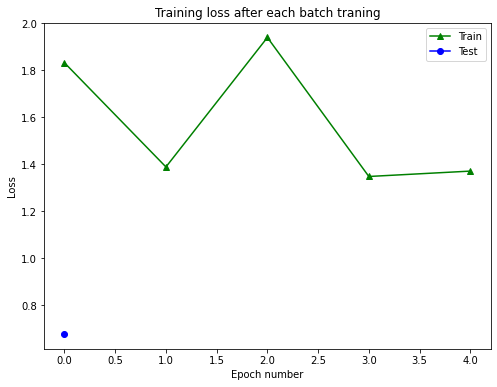

In [ ]:
plt.figure(figsize = (8,6))
plt.plot(training_loss, color = 'green', marker = '^', label = "Train")
plt.plot(testing_loss, color = 'blue', marker = 'o', label = 'Test')
plt.title("Training loss after each batch traning")
plt.xlabel("Epoch number")
plt.ylabel("Loss")
plt.legend()
plt.show()

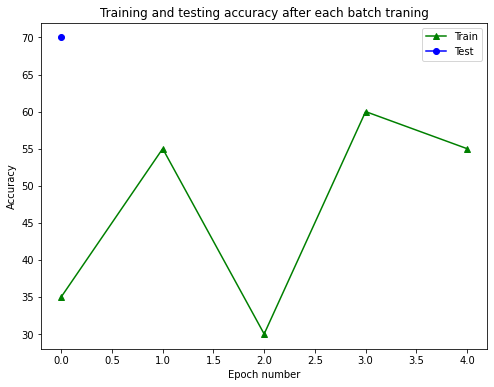

In [ ]:
plt.figure(figsize = (8,6))
plt.plot(training_accuracy, color = 'green', marker = '^', label = "Train")
plt.plot(testing_accuracy, color = 'blue', marker = 'o', label = 'Test')
plt.title("Training and testing accuracy after each batch traning")
plt.xlabel("Epoch number")
plt.ylabel("Accuracy")
plt.legend()
plt.show()